# Comparing the GCs in Abell2744 to its lensing map

* Photometric catalogue of GCs from Harris & Reina-Campos 2023
* Lensing map from the UNCOVER team - Furtak+ 2023

In [1]:
# Import modules
import sys, numpy, os, glob, scipy, pandas
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy import constants
from astropy.cosmology import Planck18, z_at_value
from astropy.table import Table

mpl.rcParams["text.usetex"] = False
mpl.rcParams["font.size"] = 18.0
mpl.rcParams["legend.fontsize"] = 16.0
mpl.rcParams["xtick.major.size"] = 10
mpl.rcParams["xtick.minor.size"] = 5
mpl.rcParams["ytick.major.size"] = 10
mpl.rcParams["ytick.minor.size"] = 5

## Load the photometric catalogue of GCs

In [2]:
out_path = os.path.join(".", "imgs")

# luminosity distance to Abell2744
distance_to_a2744 = 1630 * u.Mpc

# input path of the photometric catalogue
inpath = os.path.join("..", "Harris23_Abell2744_GCs")
ls_files = glob.glob(
    os.path.join(inpath, "2404_00_catalogue_GCs_A2744_originalmosaic_psky*")
)

# read the photometric catalogue
# OLD -- gc_catalogue = pandas.read_csv(ls_files[0], sep='\s+', engine='python', skiprows = 3, index_col = False,
#                               names = ["RA(J2000)", "DEC(J2000)", "x[px]", "y[px]", "prob", "F115W", "F150W", "F200W", "sky", "sigsky"])

# gc_catalogue = pandas.read_csv(ls_files[0], sep='\s+', engine='python', skiprows = 3, index_col = False,
#                               names = ["RA [J2000]", "DEC[J2000]", "x[orig px]", "y[orig px]", "prob", "F115W", "F150W", "F200W","sky", "sigsky"])
gc_catalogue = Table.read(
    ls_files[0],
    format="ascii",
    names=(
        "RA [J2000]",
        "DEC [J2000]",
        "x[orig px]",
        "y[orig px]",
        "prob",
        "F115W",
        "F150W",
        "F200W",
        "sky",
        "sigsky",
    ),
    units=(u.deg, u.deg, "", "", "", "", "", "", "", ""),
)
# distance modulus
DM = 41.06
K_F115 = 0.17
K_F150 = 0.17
K_F200 = 0.42
# coordinates in physical units
image_angular_size = 92  # pc per pixel
gc_catalogue["x[orig kpc]"] = gc_catalogue["x[orig px]"] * image_angular_size / 1000
gc_catalogue["y[orig kpc]"] = gc_catalogue["y[orig px]"] * image_angular_size / 1000
# K-corrected apparent magnitudes
gc_catalogue["F115W0"] = gc_catalogue["F115W"] + K_F115
gc_catalogue["F150W0"] = gc_catalogue["F150W"] + K_F150
gc_catalogue["F200W0"] = gc_catalogue["F200W"] + K_F200

# K-corrected absolute magnitudes
gc_catalogue["M_F115W0"] = gc_catalogue["F115W"] + K_F115 - DM
gc_catalogue["M_F150W0"] = gc_catalogue["F150W"] + K_F150 - DM
gc_catalogue["M_F200W0"] = gc_catalogue["F200W"] + K_F200 - DM

# determine the four sky zones
gc_catalogue["Zone"] = 0
mask = numpy.log10(gc_catalogue["sigsky"]) <= 1.8
gc_catalogue["Zone"][mask] = 1
mask = (numpy.log10(gc_catalogue["sigsky"]) > 1.8) * (
    numpy.log10(gc_catalogue["sigsky"]) <= 2.1
)
gc_catalogue["Zone"][mask] = 2
mask = (numpy.log10(gc_catalogue["sigsky"]) > 2.1) * (
    numpy.log10(gc_catalogue["sigsky"]) <= 2.4
)
gc_catalogue["Zone"][mask] = 3
mask = numpy.log10(gc_catalogue["sigsky"]) > 2.4
gc_catalogue["Zone"][mask] = 4

# select only the zone 1 GCs
cat_zone1 = gc_catalogue[gc_catalogue["Zone"] == 1].copy()

# from Harris & Reina-Campos 2023
arcsec_kpc = (
    2100 * u.kpc / (460 * u.arcsec)
)  # conversion between arcsec and kpc at the distance of Abell 2744

### Figure: spatial distribution of GCs in Abell2744 colourcoded by the recovery fraction

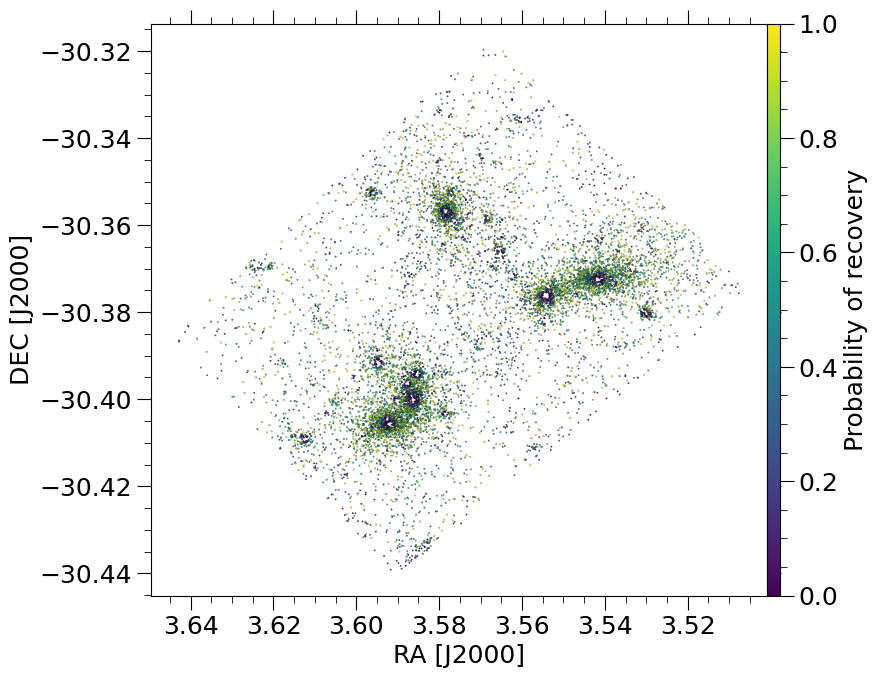

In [3]:
# create the Figure object
fig, ax = plt.subplots(1, figsize=(8, 6.5), sharex=True)
ax = numpy.atleast_1d(ax)
ax = ax.ravel()

left = 0.1
right = 0.87
top = 0.98
bottom = 0.1
hspace = 0.0
wspace = 0.0

# plot the recovered GCs
cmap = plt.get_cmap("viridis")
norm = mpl.colors.Normalize(0, 1)
ax[0].scatter(
    gc_catalogue["RA [J2000]"],
    gc_catalogue["DEC [J2000]"],
    c=gc_catalogue["prob"],
    cmap=cmap,
    norm=norm,
    s=5,
    marker=".",
    edgecolor="k",
    linewidth=0.1,
    zorder=10,
)

# add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# add an inset axes for the colorbar
cax = ax[0].inset_axes([1.001, 0.0, 0.02, 1.0])  # [x0, y0, width, height]
# create the colorbar object
cbar = fig.colorbar(sm, cax=cax, ax=ax[0])
cbar.minorticks_on()  # add minorticks
cbar.set_label("Probability of recovery")  # add label

# format all axes
for ind in range(len(ax)):
    ax[ind].invert_xaxis()
    ax[ind].set_xlabel("RA [J2000]")
    ax[ind].set_ylabel("DEC [J2000]")
    ax[ind].tick_params(
        bottom=True, left=True, right=True, top=True, axis="both", which="both"
    )
    ax[ind].minorticks_on()

# format the entire figure
fig.subplots_adjust(
    left=left, top=top, bottom=bottom, right=right, hspace=hspace, wspace=wspace
)

fname = "xy_allgcs_recovery_fraction.png"
fig.savefig(os.path.join(out_path, fname), bbox_inches="tight")

plt.show()

## Load the convergence maps

### Furtak+2023

 [astropy.io.fits.verify]


hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_z01-magnif.fits 1
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (3.64780701, -30.44001881)>


 [astropy.io.fits.verify]


hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_z02-magnif.fits 1
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (3.64780701, -30.44001881)>
hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_z04-magnif.fits 1
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (3.64780701, -30.44001881)>
hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_z06-magnif.fits 1
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (3.64780701, -30.44001881)>
hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_z08-magnif.fits 1
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (3.64780701, -30.44001881)>
hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_z010-magnif.fits 1
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (3.64780701, -30.44001881)>
hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_z015-magnif.fits 1
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (3.64780701, -30.44001881)>
hlsp_uncover_model_a2744_zitrin-dPIE-PIEMD_z020-magnif.fits 1
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (3.64780701, -30.4400188

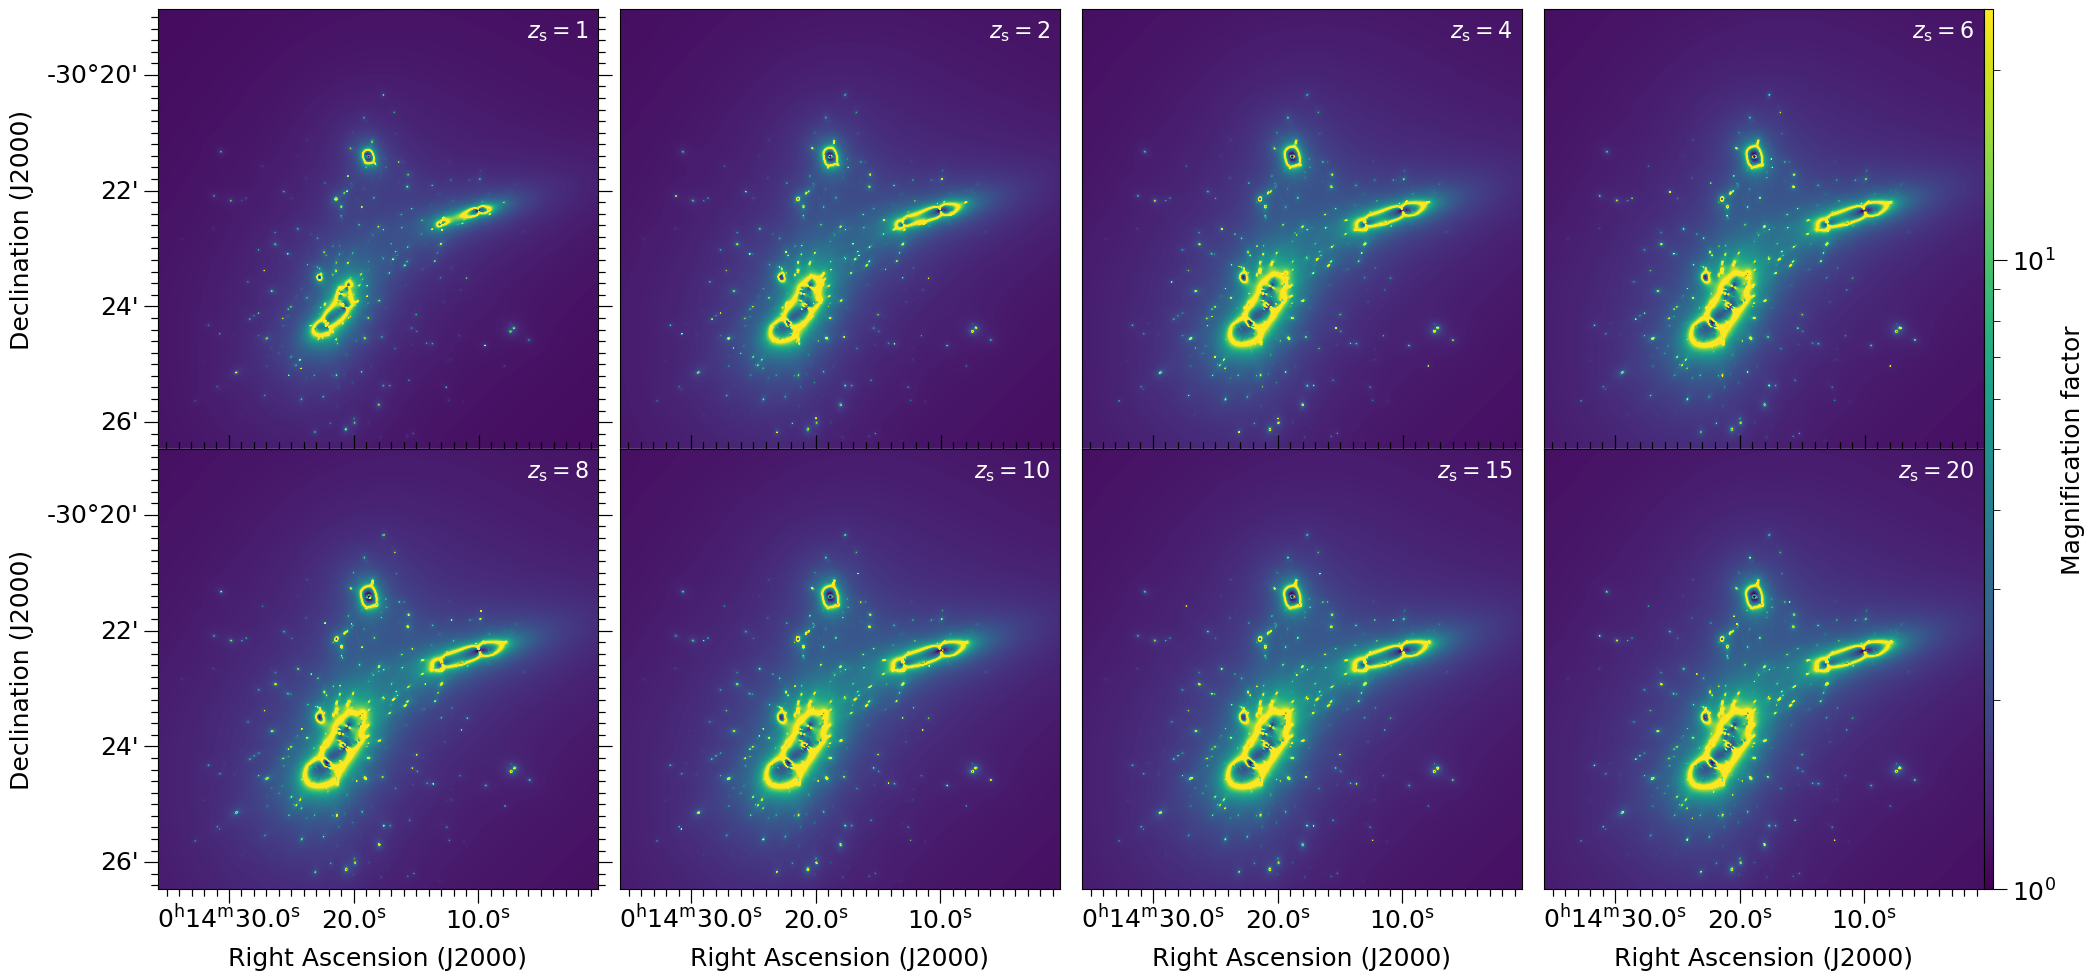

In [4]:
# input path of the photometric catalogue
inpath = os.path.join("..", "LensingMap_Furtak23", "Best-model_low-resolution_100mas")
ls_files = glob.glob(os.path.join(inpath, "*-magnif.fits"))
# ls_files.sort()
ls_files = sorted(
    ls_files, key=lambda x: int(x.split("/")[-1].split("_")[-1].split("-")[0][1:])
)  # sort by redshift

# format the figure
left = 0.1
right = 0.87
top = 0.98
bottom = 0.1
hspace = 0.0
wspace = 0.0

# normalize all panels equally
cmap = plt.get_cmap("viridis")
norm = mpl.colors.LogNorm(vmin=1, vmax=25)

# load each of the magnification maps
for i, fname in enumerate(ls_files):
    try:
        # load the FITS table
        hdul = fits.open(fname, output_verify="fix")

    except Exception as e:
        print(fname, e)
        continue

    print(fname.split("/")[-1], len(hdul))
    # load the header in the correct WCS format
    wcs = WCS(hdul[0].header)
    # converting between pixel to world coordinates
    sky = wcs.pixel_to_world(30, 40)
    print(sky)
    if i == 0:
        # create the Figure object with the correct WCS coordinates
        fig, axs = plt.subplots(
            2,
            4,
            figsize=(24, 10),
            sharex=True,
            sharey=True,
            subplot_kw={"projection": wcs},
        )
        axs = numpy.atleast_1d(axs)
        axs = axs.ravel()

    # show the data
    axs[i].imshow(hdul[0].data, norm=norm, cmap="viridis", origin="lower")
    zs = int(fname.split("/")[-1].split("_")[-1].split("-")[0][1:])
    axs[i].annotate(
        r"$z_{{\rm s}} = {:d}$".format(zs),
        xy=(0.98, 0.98),
        xycoords="axes fraction",
        ha="right",
        va="top",
        fontsize=16,
        fontweight="bold",
        color="white",
    )
    hdul.close()

# add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# add an inset axes for the colorbar
cax = axs[-1].inset_axes([1.001, 0.0, 0.02, 2.0])  # [x0, y0, width, height]
# create the colorbar object
cbar = fig.colorbar(sm, cax=cax, ax=axs[0])
cbar.minorticks_on()  # add minorticks
cbar.set_label("Magnification factor")  # add label

# format all axes
for j, ax in enumerate(axs):
    ra = ax.coords[0]
    dec = ax.coords[1]

    if j % 4 == 0:
        dec.set_axislabel("Declination (J2000)")
    else:
        dec.set_ticks_visible(False)
        dec.set_ticklabel_visible(False)
        dec.set_axislabel("")

    if j >= 4:
        ra.set_axislabel("Right Ascension (J2000)")
    else:
        ra.set_ticks_visible(False)
        ra.set_ticklabel_visible(False)
        ra.set_axislabel("")

    # set the formatting of the axes
    ra.set_major_formatter("hh:mm:ss.s")
    dec.set_major_formatter("dd:mm")

    # ax.tick_params(bottom = True, left= True, right = True, top = True, axis = "both", which = "both")
    # display minor ticks
    ra.display_minor_ticks(True)
    dec.display_minor_ticks(True)
    ra.set_minor_frequency(10)
    dec.set_minor_frequency(10)

# format the entire figure
fig.subplots_adjust(
    left=left, top=top, bottom=bottom, right=right, hspace=hspace, wspace=wspace
)

fname = "xy_furtak23_lensing_allzs.png"
fig.savefig(os.path.join(out_path, fname), bbox_inches="tight")

plt.show()

## Convergence map from Furtak+ (2023)

In [7]:
# input path of the photometric catalogue
inpath = os.path.join(
    os.curdir, "LensingMap_Furtak23", "Best-model_low-resolution_100mas"
)
ls_files = glob.glob(os.path.join(inpath, "*_kappa.fits"))

# format the figure
left = 0.1
right = 0.87
top = 0.98
bottom = 0.1
hspace = 0.0
wspace = 0.0

# normalize all panels equally
cmap = plt.get_cmap("viridis")
norm = mpl.colors.LogNorm(vmin=0.01, vmax=25)

# load each of the magnification maps
for i, fname in enumerate(ls_files):
    try:
        # load the FITS table
        hdul = fits.open(fname, output_verify="fix")

    except Exception as e:
        print(fname, e)
        continue

    # load the header in the correct WCS format
    wcs = WCS(hdul[0].header)

    if i == 0:
        # create the Figure object with the correct WCS coordinates
        fig, axs = plt.subplots(
            1,
            figsize=(10, 6.5),
            sharex=True,
            sharey=True,
            subplot_kw={"projection": wcs},
        )
        axs = numpy.atleast_1d(axs)
        axs = axs.ravel()

    print(
        fname.split("/")[-1],
        hdul[0].data.min(),
        hdul[0].data.max(),
        numpy.sum(numpy.isnan(hdul[0].data)),
    )

    axs[i].imshow(hdul[0].data, norm=norm, cmap="viridis", origin="lower")
    hdul.close()

# add the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# add an inset axes for the colorbar
cax = axs[-1].inset_axes([1.001, 0.0, 0.02, 1.0])  # [x0, y0, width, height]
# create the colorbar object
cbar = fig.colorbar(sm, cax=cax, ax=axs[0])
cbar.minorticks_on()  # add minorticks
cbar.set_label("$\kappa$")  # add label

# format all axes
for j, ax in enumerate(axs):
    ra = ax.coords[0]
    dec = ax.coords[1]

    if j % 4 == 0:
        dec.set_axislabel("Declination (J2000)")
    else:
        dec.set_ticks_visible(False)
        dec.set_ticklabel_visible(False)
        dec.set_axislabel("")

    ra.set_axislabel("Right Ascension (J2000)")
    # else:
    #    ra.set_ticks_visible(False)
    #    ra.set_ticklabel_visible(False)
    #    ra.set_axislabel('')

    # set the formatting of the axes
    ra.set_major_formatter("hh:mm:ss.s")
    dec.set_major_formatter("dd:mm")

    # ax.tick_params(bottom = True, left= True, right = True, top = True, axis = "both", which = "both")
    # display minor ticks
    ra.display_minor_ticks(True)
    dec.display_minor_ticks(True)
    ra.set_minor_frequency(10)
    dec.set_minor_frequency(10)

# format the entire figure
fig.subplots_adjust(
    left=left, top=top, bottom=bottom, right=right, hspace=hspace, wspace=wspace
)

fname = "xy_furtak23_kappa.png"
fig.savefig(os.path.join(out_path, fname), bbox_inches="tight")

plt.show()

In [8]:
# input path of the photometric catalogue
inpath = os.path.join(
    os.curdir, "LensingMap_Furtak23", "Best-model_low-resolution_100mas"
)
ls_files = glob.glob(os.path.join(inpath, "*.fits"))
ls_files_selected = [
    x
    for x in ls_files
    if (("kappa" in x) or ("psi" in x) or ("gamma" in x) or ("_magnif" in x))
]


# format the figure
left = 0.1
right = 0.87
top = 0.98
bottom = 0.1
hspace = 0.0
wspace = 0.3

# normalize all panels equally
cmap = plt.get_cmap("viridis")
norm = mpl.colors.LogNorm(vmin=1e-3, vmax=1)

# load each of the magnification maps
for i, fname in enumerate(ls_files_selected):
    try:
        # load the FITS table
        hdul = fits.open(fname, output_verify="fix")

    except Exception as e:
        print(fname, e)
        continue

    # load the header in the correct WCS format
    wcs = WCS(hdul[0].header)

    if i == 0:
        # create the Figure object with the correct WCS coordinates
        fig, axs = plt.subplots(
            1,
            4,
            figsize=(24, 6.5),
            sharex=True,
            sharey=True,
            subplot_kw={"projection": wcs},
        )
        axs = numpy.atleast_1d(axs)
        axs = axs.ravel()

    print(
        fname.split("/")[-1],
        hdul[0].data.min(),
        hdul[0].data.max(),
        numpy.sum(numpy.isnan(hdul[0].data)),
    )

    if numpy.sum(numpy.isnan(hdul[0].data)):
        hdul[0].data[numpy.isnan(hdul[0].data)] = 1e-11
    print(
        fname.split("/")[-1],
        hdul[0].data.min(),
        hdul[0].data.max(),
        numpy.sum(numpy.isnan(hdul[0].data)),
    )

    axs[i].imshow(
        abs(hdul[0].data / hdul[0].data.max()),
        norm=norm,
        cmap="viridis",
        origin="lower",
    )
    hdul.close()
    label = fname.split("/")[-1].split("_")[-1].split(".")[0]

    # add the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # add an inset axes for the colorbar
    cax = axs[i].inset_axes([1.001, 0.0, 0.02, 1.0])  # [x0, y0, width, height]
    # create the colorbar object
    cbar = fig.colorbar(sm, cax=cax, ax=axs[i])
    cbar.minorticks_on()  # add minorticks
    cbar.set_label(r"|{:s}/{:s}$_{{\rm max}}$|".format(label, label))  # add label

# format all axes
for j, ax in enumerate(axs):
    ra = ax.coords[0]
    dec = ax.coords[1]

    if j % 4 == 0:
        dec.set_axislabel("Declination (J2000)")
    else:
        dec.set_ticks_visible(False)
        dec.set_ticklabel_visible(False)
        dec.set_axislabel("")

    ra.set_axislabel("Right Ascension (J2000)")
    # else:
    #    ra.set_ticks_visible(False)
    #    ra.set_ticklabel_visible(False)
    #    ra.set_axislabel('')

    # set the formatting of the axes
    ra.set_major_formatter("hh:mm:ss.s")
    dec.set_major_formatter("dd:mm")

    # ax.tick_params(bottom = True, left= True, right = True, top = True, axis = "both", which = "both")
    # display minor ticks
    ra.display_minor_ticks(True)
    dec.display_minor_ticks(True)
    ra.set_minor_frequency(10)
    dec.set_minor_frequency(10)

# format the entire figure
fig.subplots_adjust(
    left=left, top=top, bottom=bottom, right=right, hspace=hspace, wspace=wspace
)

fname = "xy_furtak23_gamma_psi_kappa_magnif.png"
fig.savefig(os.path.join(out_path, fname), bbox_inches="tight")

plt.show()